This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy


# Local imports
import sys
sys.path.append('../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds

CUDA not available.


In [2]:
%matplotlib notebook

In [20]:
# Specify the input data
# case = 'case4.2 (calibration)'
# imageroot = 'figure'
# Segmentnamelistroot = 'Segments'
# Calibrationfile = 'case4.2 (calibration)/Calibration.nml'

case = 'case4.9 rougher'
imageroot = 'figure'
Segmentnamelistroot = 'Segments2'
Calibrationfile = 'case4.2 (calibration)/Calibration.nml'


In [21]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = case+'/'+Segmentnamelist
SEMSegmentjpgfile =  case+'/'+Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   case+'/'+Segmentnamelistroot+'retrieved.jpg'
Compressedfilename = case+'/'+Segmentnamelistroot+'retrieved'
SEMSegmentjpgfile =  case+'/'+Segmentnamelistroot+'.jpg'

In [22]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2(case, '/SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

Filename, dx and dy case4.9 rougher/SEMimages/figure-D.bmp 0.6614583 0.6614583


<IPython.core.display.Javascript object>


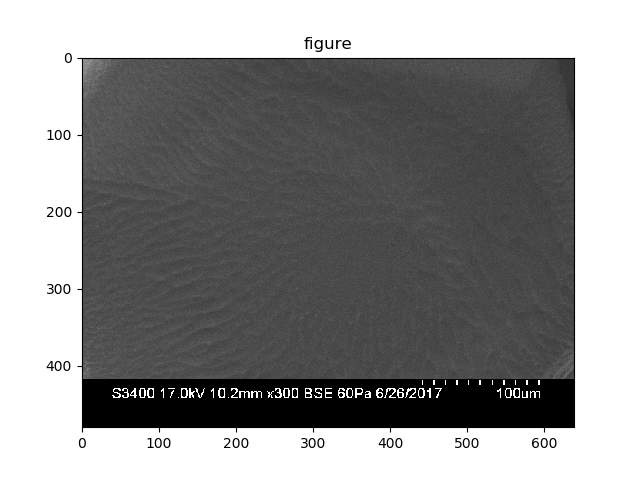

Text(0.5,1,'figure')

In [25]:
# Show just the image (in case we want to look at it before defining the segments)
fig, ax = plt.subplots()
ax.set_title(imageroot)
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
ax.set_title(imageroot)

<IPython.core.display.Javascript object>


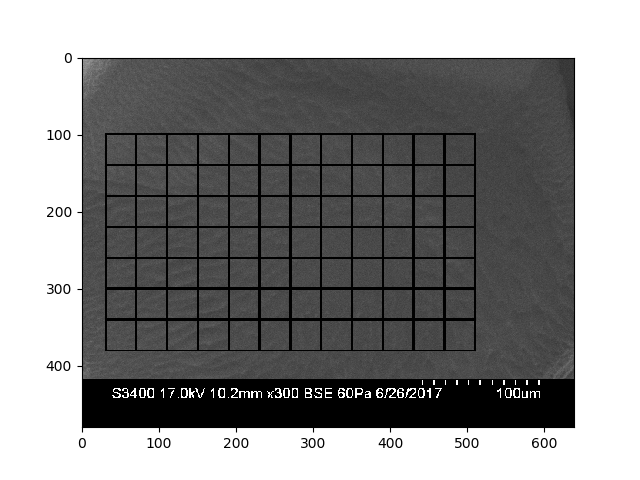

In [28]:
# Show the image with segment data
fig, ax = plt.subplots()

# Extract
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)

ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)

# Save a copy
fig.savefig(SEMSegmentjpgfile)

In [29]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']


case4.2 (calibration)/Calibration.nml


In [30]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [31]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [32]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [33]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [34]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [35]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
noiseamp = 5.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 2.23606797749979
Std deviation in a priori is 15.0


In [36]:
# Loop to retrieve each segment
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    vartemp_long = np.reshape(vartemp,nzpts+1,0)
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("for", nx1, ny1)
    print("Segment:", isegment+1, "of", nsegments)
    z_retrieved = fbs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


for 30 100
Segment: 1 of 84
statistics of observed intensities (detector B):
mean = 66.293125
max = 80.0
min = 55.0
iteration, di2 0 [[26641.38815613]]
iteration, di2 1 [[48.52695281]]
iteration, di2 2 [[0.5251612]]

for 30 140
Segment: 2 of 84
statistics of observed intensities (detector B):
mean = 70.658125
max = 94.0
min = 57.0
iteration, di2 0 [[13839.7693816]]
iteration, di2 1 [[31.08389223]]
iteration, di2 2 [[0.28725339]]
Noverlap = 41

for 30 180
Segment: 3 of 84
statistics of observed intensities (detector B):
mean = 75.628125
max = 92.0
min = 61.0
iteration, di2 0 [[16334.27437938]]
iteration, di2 1 [[40.29996724]]
iteration, di2 2 [[0.29892808]]
Noverlap = 41

for 30 220
Segment: 4 of 84
statistics of observed intensities (detector B):
mean = 79.3175
max = 99.0
min = 63.0
iteration, di2 0 [[35653.21166137]]
iteration, di2 1 [[43.10865927]]
iteration, di2 2 [[0.21149221]]
Noverlap = 41

for 30 260
Segment: 5 of 84
statistics of observed intensities (detector B):
mean = 83.30

iteration, di2 0 [[48712.8694039]]
iteration, di2 1 [[56.45980457]]
iteration, di2 2 [[1.14343576]]
Noverlap = 42

for 230 140
Segment: 37 of 84
statistics of observed intensities (detector B):
mean = 68.255625
max = 81.0
min = 55.0
iteration, di2 0 [[39309.76346118]]
iteration, di2 1 [[42.34773888]]
iteration, di2 2 [[0.76820684]]
Noverlap = 84

for 230 180
Segment: 38 of 84
statistics of observed intensities (detector B):
mean = 70.839375
max = 85.0
min = 59.0
iteration, di2 0 [[31299.96842388]]
iteration, di2 1 [[36.55255316]]
iteration, di2 2 [[0.5108755]]
Noverlap = 84

for 230 220
Segment: 39 of 84
statistics of observed intensities (detector B):
mean = 74.098125
max = 90.0
min = 59.0
iteration, di2 0 [[30592.74793256]]
iteration, di2 1 [[33.11141753]]
iteration, di2 2 [[0.37097592]]
Noverlap = 84

for 230 260
Segment: 40 of 84
statistics of observed intensities (detector B):
mean = 77.4225
max = 94.0
min = 63.0
iteration, di2 0 [[34128.13218477]]
iteration, di2 1 [[43.60362843]]

iteration, di2 0 [[105885.14354534]]
iteration, di2 1 [[82.38283785]]
iteration, di2 2 [[1.47172518]]
Noverlap = 42

for 430 140
Segment: 72 of 84
statistics of observed intensities (detector B):
mean = 66.97
max = 81.0
min = 53.0
iteration, di2 0 [[129024.31382363]]
iteration, di2 1 [[369.84552067]]
iteration, di2 2 [[3.47901195]]
Noverlap = 84

for 430 180
Segment: 73 of 84
statistics of observed intensities (detector B):
mean = 68.036875
max = 82.0
min = 54.0
iteration, di2 0 [[157779.27494052]]
iteration, di2 1 [[1250.93016365]]
iteration, di2 2 [[6.98861982]]
Noverlap = 84

for 430 220
Segment: 74 of 84
statistics of observed intensities (detector B):
mean = 72.663125
max = 85.0
min = 60.0
iteration, di2 0 [[146619.47414183]]
iteration, di2 1 [[1273.17322271]]
iteration, di2 2 [[6.34536579]]
Noverlap = 84

for 430 260
Segment: 75 of 84
statistics of observed intensities (detector B):
mean = 76.23375
max = 98.0
min = 61.0
iteration, di2 0 [[128756.61747778]]
iteration, di2 1 [[904.

480
280


<IPython.core.display.Javascript object>


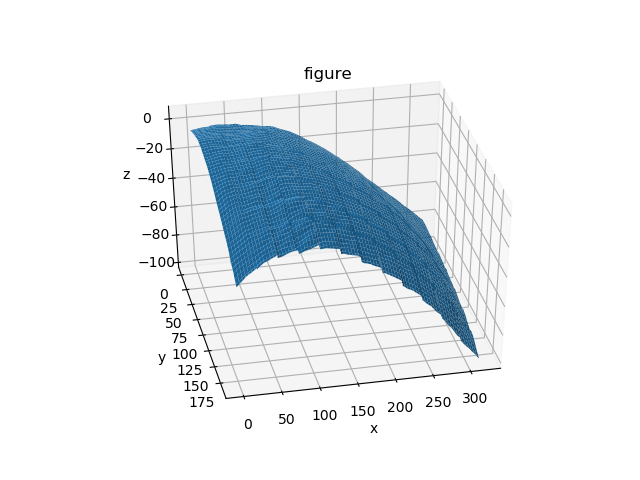

In [39]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=6,cstride=6)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [38]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving case4.9 rougher/Segments2retrieved
